In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
from datetime import date

In [4]:
#Open JSON File
tamis="transaction-data-adhoc-analysis.json"
tamis_df=pd.read_json(tamis)
tamis_df

,address,birthdate,mail,name,sex,username,transaction_items,transaction_value,transaction_date
0,USNS Wagner\nFPO AE 00917,1926/03/11,watsonbrenda@gmail.com,Jennifer Campbell,F,veronicawells,"Exotic Extras,Beef Chicharon,(x4)",5196,2022/01/12
1,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,cgilbert,"Exotic Extras,Beef Chicharon,(x3);HealthyKid 3...",12056,2022/01/12
2,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,cgilbert,"HealthyKid 3+,Gummy Vitamins,(x3);HealthyKid 3...",5500,2022/01/08
3,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,cgilbert,"HealthyKid 3+,Yummy Vegetables,(x1)",500,2022/01/10
4,"33911 Hansen Loaf\nWest Sandra, ND 54188",1949/09/27,michael78@yahoo.com,Kristen Cooper,F,qhernandez,"Candy City,Orange Beans,(x3);Candy City,Gummy ...",2697,2022/01/24
...,...,...,...,...,...,...,...,...,...
83031,"96081 Harrison Brooks\nJenniferbury, MA 02124",2019/10/26,christina55@hotmail.com,Tammy Byrd,F,kmcconnell,"Exotic Extras,Kimchi and Seaweed,(x2);HealthyK...",3588,2022/06/05
83032,428 Kristopher Curve Apt. 206\nMcculloughville...,1913/11/04,melvinschmidt@hotmail.com,Donald Andersen,M,llowe,"HealthyKid 3+,Yummy Vegetables,(x1);Exotic Ext...",2095,2022/06/12
83033,428 Kristopher Curve Apt. 206\nMcculloughville...,1913/11/04,melvinschmidt@hotmail.com,Donald Andersen,M,llowe,"Candy City,Orange Beans,(x4);Candy City,Gummy ...",3396,2022/06/15
83034,428 Kristopher Curve Apt. 206\nMcculloughville...,1913/11/04,melvinschmidt@hotmail.com,Donald Andersen,M,llowe,"HealthyKid 3+,Nutrional Milk,(x2);Candy City,G...",4280,2022/06/09


In [5]:
#Get unique products and their respective prices
products_df = tamis_df.copy()

unique_product=products_df.transaction_items.str.split(";")
products_df = products_df.assign(transaction_items=unique_product)
products_df = products_df[products_df["transaction_items"].apply(len)==1]

products_df["transaction_items"] = products_df["transaction_items"].apply(lambda lst: lst[0])
products_df["Amount"] = products_df["transaction_items"].apply(lambda x: int(x.split(',')[-1].strip('(x)')))
products_df["transaction_items"] = products_df["transaction_items"].apply(lambda lst: lst[:-5])

products_df = products_df.drop_duplicates(subset="transaction_items", keep="first")
label = list(products_df["transaction_items"].values)
products_df = products_df["transaction_value"] / products_df["Amount"]

products_df.index = label

products_df

Exotic Extras,Beef Chicharon        1299.0
HealthyKid 3+,Yummy Vegetables       500.0
Exotic Extras,Kimchi and Seaweed     799.0
Candy City,Gummy Worms               150.0
HealthyKid 3+,Gummy Vitamins        1500.0
HealthyKid 3+,Nutrional Milk        1990.0
Candy City,Orange Beans              199.0
dtype: float64

In [6]:
#Explode unique orders by each customer into different rows
unique_product=tamis_df.transaction_items.str.split(";")
data_df = tamis_df.assign(transaction_items=unique_product).explode('transaction_items')

data_df["Quantity per Item"] = data_df["transaction_items"].apply(lambda x: int(x.split(',')[-1].strip('(x)')))
data_df["transaction_items"] = data_df["transaction_items"].apply(lambda lst: lst[:-5])
data_df["Total Price per Product"] = data_df["Quantity per Item"] * data_df["transaction_items"].apply(lambda x: products_df.loc[x])

#Get month of when order was made
def month_date(x):    
    month = int(x[6:len(x)-3])
    a = calendar.month_name[month]
    return a

data_df["Month of Transaction"] = data_df["transaction_date"].apply(month_date).astype(pd.api.types.CategoricalDtype(categories=['January','February','March','April','May','June']))

#Arrange dataframe
data_df["Transaction Items"]=data_df["transaction_items"]
del data_df["transaction_items"]

data_df.rename(columns={'name':'Customer Name','transaction_value':'Total Transaction Value','transaction_date':'Transaction Date','username':'Username'},inplace=True)
data_df=data_df[['Customer Name','Username','Transaction Items','Quantity per Item','Total Price per Product','Total Transaction Value','Transaction Date','Month of Transaction']]

data_df

,Customer Name,Username,Transaction Items,Quantity per Item,Total Price per Product,Total Transaction Value,Transaction Date,Month of Transaction
0,Jennifer Campbell,veronicawells,"Exotic Extras,Beef Chicharon",4,5196.0,5196,2022/01/12,January
1,Melissa Kim,cgilbert,"Exotic Extras,Beef Chicharon",3,3897.0,12056,2022/01/12,January
1,Melissa Kim,cgilbert,"HealthyKid 3+,Nutrional Milk",4,7960.0,12056,2022/01/12,January
1,Melissa Kim,cgilbert,"Candy City,Orange Beans",1,199.0,12056,2022/01/12,January
2,Melissa Kim,cgilbert,"HealthyKid 3+,Gummy Vitamins",3,4500.0,5500,2022/01/08,January
...,...,...,...,...,...,...,...,...
83034,Donald Andersen,llowe,"HealthyKid 3+,Nutrional Milk",2,3980.0,4280,2022/06/09,June
83034,Donald Andersen,llowe,"Candy City,Gummy Worms",2,300.0,4280,2022/06/09,June
83035,Stephanie Russell,cmcdowell,"HealthyKid 3+,Nutrional Milk",1,1990.0,2639,2022/06/03,June
83035,Stephanie Russell,cmcdowell,"Candy City,Gummy Worms",3,450.0,2639,2022/06/03,June


In [8]:
#Breakdown of the count of each item sold per month
total_count_per_item=pd.pivot_table(data_df,index="Transaction Items",columns="Month of Transaction",values="Quantity per Item",aggfunc=sum)

total_count_per_item

Month of Transaction,January,February,March,April,May,June
Transaction Items,,,,,,
"Candy City,Gummy Worms",9559,9996,9986,10043,9801,9934
"Candy City,Orange Beans",9774,10037,9611,9914,9964,10106
"Exotic Extras,Beef Chicharon",9665,10001,9816,9890,10028,9902
"Exotic Extras,Kimchi and Seaweed",9676,9949,9967,9921,9773,10104
"HealthyKid 3+,Gummy Vitamins",9681,9980,10145,9842,9948,9980
"HealthyKid 3+,Nutrional Milk",9727,9691,9876,9786,9881,9767
"HealthyKid 3+,Yummy Vegetables",9959,10256,9896,9861,9735,9722


In [9]:
#Breakdown of the total sale value per item per month
total_sales_per_item=pd.pivot_table(data_df,index="Transaction Items",columns="Month of Transaction",values="Total Price per Product",aggfunc=sum)

total_sales_per_item

Month of Transaction,January,February,March,April,May,June
Transaction Items,,,,,,
"Candy City,Gummy Worms",1433850.0,1499400.0,1497900.0,1506450.0,1470150.0,1490100.0
"Candy City,Orange Beans",1945026.0,1997363.0,1912589.0,1972886.0,1982836.0,2011094.0
"Exotic Extras,Beef Chicharon",12554835.0,12991299.0,12750984.0,12847110.0,13026372.0,12862698.0
"Exotic Extras,Kimchi and Seaweed",7731124.0,7949251.0,7963633.0,7926879.0,7808627.0,8073096.0
"HealthyKid 3+,Gummy Vitamins",14521500.0,14970000.0,15217500.0,14763000.0,14922000.0,14970000.0
"HealthyKid 3+,Nutrional Milk",19356730.0,19285090.0,19653240.0,19474140.0,19663190.0,19436330.0
"HealthyKid 3+,Yummy Vegetables",4979500.0,5128000.0,4948000.0,4930500.0,4867500.0,4861000.0


<AxesSubplot:ylabel='Transaction Items'>

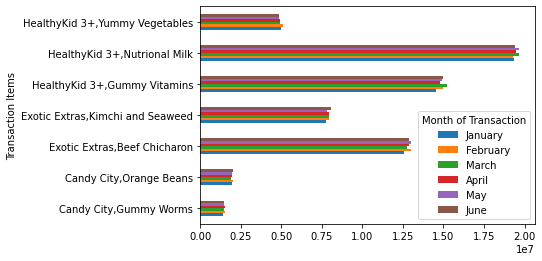

In [10]:
total_sales_per_item.plot.barh()

In [11]:
#Breakdown of total number of items sold and total sales per month
sales_df=data_df.copy()
sales_df['Total Sales']=sales_df['Total Price per Product']

tamis_sales=pd.pivot_table(sales_df,index="Month of Transaction",values=["Quantity per Item","Total Sales"],aggfunc=sum, margins=True, margins_name='Grand Total')
tamis_sales

,Quantity per Item,Total Sales
Month of Transaction,,
January,68041,62522565.0
February,69910,63820403.0
March,69297,63943846.0
April,69257,63420965.0
May,69130,63740675.0
June,69515,63704318.0
Grand Total,415150,381152772.0


In [12]:
#Breakdown of number of orders made by each customer
customers_df = data_df[['Customer Name','Quantity per Item','Month of Transaction']]
customers_df = pd.pivot_table(customers_df, values="Quantity per Item", index="Customer Name", columns="Month of Transaction", aggfunc=sum,fill_value = 0)

customers_df

Month of Transaction,January,February,March,April,May,June
Customer Name,,,,,,
Aaron Beasley,0,0,0,9,8,1
Aaron Brewer,4,6,1,9,0,13
Aaron Brown,0,0,20,14,8,1
Aaron Coffey,1,7,9,12,12,0
Aaron Davis,6,1,0,15,15,12
...,...,...,...,...,...,...
Zachary Valentine,7,6,3,2,14,19
Zachary Ware,6,9,16,5,10,8
Zachary Williams,24,23,19,14,0,0


In [13]:
repeaters=customers_df.copy()

repeaters['January'] = 0

repeaters['February'] = np.where((customers_df['January'] >=1) & (customers_df['February'] >=1),1,0)

repeaters['March'] = np.where((customers_df['February'] >=1) & (customers_df['March'] >=1),1,0)

repeaters['April'] = np.where((customers_df['March'] >=1) & (customers_df['April'] >=1),1,0)

repeaters['May'] = np.where((customers_df['April'] >=1) & (customers_df['May'] >=1),1,0)

repeaters['June'] = np.where((customers_df['May'] >=1) & (customers_df['June'] >=1),1,0)

repeaters=pd.DataFrame(repeaters.sum(), columns=["Repeater"], copy=False)

repeaters.transpose()

Month of Transaction,January,February,March,April,May,June
Repeater,0,5172,5216,5154,5110,5193


In [14]:
inactives=customers_df.copy()

inactives['January'] = 0

inactives['February'] = np.where((customers_df['January'] >=1) & (customers_df['February'] ==0),1,0)

inactives['March'] = np.where(((customers_df['January'] >=1) | (customers_df['February'] >=1)) & (customers_df['March'] ==0),1,0)

inactives['April'] = np.where(((customers_df['January'] >=1) | (customers_df['February'] >=1) | (customers_df['March'] >=1)) & (customers_df['April'] ==0),1,0)

inactives['May'] = np.where(((customers_df['January'] >=1) | (customers_df['February'] >=1) | (customers_df['March'] >=1) | (customers_df['April'] >=1)) & (customers_df['May'] ==0),1,0)
                            
inactives['June'] = np.where(((customers_df['January'] >=1) | (customers_df['February'] >=1) | (customers_df['March'] >=1) | (customers_df['April'] >=1) | (customers_df['May'] >=1)) & (customers_df['June'] ==0),1,0)

inactives= pd.DataFrame(inactives.sum(), columns = ["Inactive"], copy=False)

inactives.transpose()

Month of Transaction,January,February,March,April,May,June
Inactive,0,1416,1747,1909,1917,1835


In [15]:
engaged=customers_df.copy()

engaged['January'] = np.where((customers_df['January'] >0),1,0)

engaged['February'] = np.where((customers_df['January'] >0) & (customers_df['February'] >0),1,0)

engaged['March'] = np.where((customers_df['January'] >0) & (customers_df['February'] >0) & (customers_df['March'] >0),1,0)

engaged['April'] = np.where ((customers_df['January'] >0) & (customers_df['February'] >0) & (customers_df['March'] >0) & (customers_df['April'] >0),1,0)

engaged['May'] = np.where ((customers_df['January'] >0) & (customers_df['February'] >0) & (customers_df['March'] >0) & (customers_df['April'] >0) & (customers_df['May'] >0),1,0)

engaged['June'] = np.where ((customers_df['January'] >0) & (customers_df['February'] >0) & (customers_df['March'] >0) & (customers_df['April'] >0) & (customers_df['May'] >0) & (customers_df['June'] >0),1,0)
    
engaged= pd.DataFrame(engaged.sum(), columns = ["Engaged"], copy=False)

engaged.transpose()

Month of Transaction,January,February,March,April,May,June
Engaged,6588,5172,4126,3289,2667,2190


In [16]:
from functools import reduce

df=[repeaters,inactives,engaged]

final_df = reduce(lambda left,right: pd.merge(left,right,on=['Month of Transaction'], how='outer'), df)

final_df.transpose()

Month of Transaction,January,February,March,April,May,June
Repeater,0,5172,5216,5154,5110,5193
Inactive,0,1416,1747,1909,1917,1835
Engaged,6588,5172,4126,3289,2667,2190


In [18]:
def age(x):
    year=int(x[:len(x)-6])
    a=date.today().year-year
    return int(a)

def age_group(x):
    if 0< x <=14:
        return "Child"
    elif 15<= x <=24:
        return "Youth"
    elif 25<= x <=64:
        return "Adult"
    elif x>=65:
        return "Senior"

In [19]:
age_df=tamis_df.copy()

age_df['Age']=age_df['birthdate'].apply(age)
age_df['Age Group']=age_df['Age'].apply(age_group)
age_df["Month of Transaction"]=age_df["transaction_date"].apply(month_date).astype(pd.api.types.CategoricalDtype(categories=['January','February','March','April','May','June']))
age_df=pd.DataFrame().assign(Age=age_df['Age'],AgeGroup=age_df['Age Group'],Month=age_df['Month of Transaction'])

Text(0, 0.5, 'Number of Transactions')

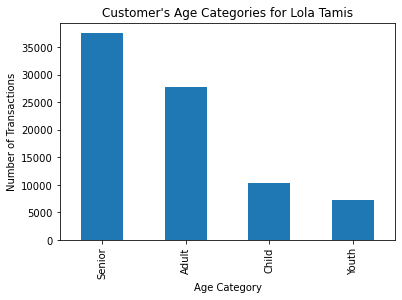

In [23]:
age_category=age_df['AgeGroup'].value_counts()
age_category.plot.bar()
plt.title("Customer's Age Categories for Lola Tamis")
plt.xlabel('Age Category')
plt.ylabel('Number of Transactions')

In [25]:
age_category=age_df['AgeGroup'].value_counts()
age_category

Senior    37581
Adult     27686
Child     10263
Youth      7216
Name: AgeGroup, dtype: int64